# Comparison of Two Time Series of Maps 0.1
*This notebook implements the framework from the article “Foundational concepts and equations to compare two time series of maps” to quantify and visualize agreement and change between two temporal map series. Using toy data, it defines modular Python functions to compute presence‐agreement components, gains and losses, and full‐extent change metrics, and produces visualizations and exportable results for reproducible analysis.*

## Table of Contents  
1. [Environment Setup](#environment-setup)
2. [Toy Data Input Format](#data-preparation)
3. [Presence Agreement Components](#presence-agreement)
4. [Gross Change Components](#change-components)
5. [Net Change Calculations](#full-extent)
6. [Visualization of Results](#visualization)
7. [Exporting Results](#export)


## 1. Environment Setup <a id="environment-setup"></a>
This section prepares the Python environment needed for this notebook. We will:

- Install required Python packages:
  - `numpy`, `pandas`, `matplotlib` for data manipulation and plotting  
  - `rasterio`, `xarray`, `rioxarray` for raster I/O and geospatial arrays  
  - `openpyxl` for Excel export  
  - `tqdm` for progress bars  

Execute the following cell to install the dependencies:


### 1.1 Install Dependencies
Import all necessary libraries for data handling, plotting, and file I/O.

In [1]:
# Install required packages for array math, dataframes, plotting, raster I/O, and progress bars
%pip install -qq numpy pandas matplotlib rasterio xarray rioxarray openpyxl tqdm

Note: you may need to restart the kernel to use updated packages.


### 1.2 Import Libraries  

In [2]:
# Core libraries
import numpy as np
import pandas as pd

# Display utilities
from IPython.display import display

# Plotting
import matplotlib.pyplot as plt

# Raster I/O
import rasterio
from rasterio.transform import from_origin
import xarray as xr
import rioxarray

# Progress bars and Excel export
from tqdm import tqdm
import openpyxl

# File system operations
import os


### 1.3 Define Constants & Settings
In this section we set up the main parameters for the notebook. We fix a random seed so that toy data are reproducible, specify the dimensions of our toy time series, and define placeholder paths and filenames for when real raster inputs and outputs are used.

In [3]:
# Utility Functions
def print_metrics(label, **metrics):
    """
    Prints a section label and each named metric array.
    """
    print(f"== {label} ==")
    for name, arr in metrics.items():
        print(f"{name}: {arr}")
    print()


In [4]:
# Define the prefixes for the two time series to be compared.
series_x_prefix = "savannaCol6_"  # This will be the reference series
series_y_prefix = "savannaCol8_"  # This will be the comparison series

# Define directories for input and output.
input_dir = r"C:\Users\AntFonseca\github\compare-time-series\input3"
output_dir = r"C:\Users\AntFonseca\github\compare-time-series\output3"

# Define the output filename for the Excel metrics file.
metrics_excel = "presence_change_metrics.xlsx"

# Use the utility function to print the configuration settings
print_metrics(
    "Data Input Configuration",
    Reference_Series_X=series_x_prefix,
    Comparison_Series_Y=series_y_prefix,
    Input_Directory=input_dir,
    Output_Directory=output_dir
)

== Data Input Configuration ==
Reference_Series_X: savannaCol6_
Comparison_Series_Y: savannaCol8_
Input_Directory: C:\Users\AntFonseca\github\compare-time-series\input3
Output_Directory: C:\Users\AntFonseca\github\compare-time-series\output3



## 2. Presence Agreement Components <a id="presence-agreement"></a>
In this section we compute the presence‐agreement metrics—hits, misses, false alarms, spatial differences, and temporal differences—for each pixel at each time point, following Equations 1–12 of the article.

### 2.1 Define Presence Variables:

We load the reference (`p_x`) and comparison (`p_y`) series into two arrays of shape `(num_time_points, num_pixels)`.  
Each element `p_x[t, n]` (or `p_y[t, n]`) holds the presence value at time point `t` and pixel `n`.

In [5]:
# --- Data Loading with NoData Cleaning ---

# This section loads the real raster data and cleans NoData values.

# 1. Gather and sort the raster filenames for each series.
x_files_full = sorted([
    os.path.join(input_dir, f)
    for f in os.listdir(input_dir)
    if f.startswith(series_x_prefix) and f.endswith('.tif')
])

y_files_full = sorted([
    os.path.join(input_dir, f)
    for f in os.listdir(input_dir)
    if f.startswith(series_y_prefix) and f.endswith('.tif')
])

# 2. Perform validation checks.
if not x_files_full or not y_files_full:
    raise FileNotFoundError("Could not find raster files. Check input_dir and prefixes.")
if len(x_files_full) != len(y_files_full):
    raise ValueError("The number of files for each series do not match.")

# 3. Determine dimensions dynamically from the first raster.
with rasterio.open(x_files_full[0]) as src:
    height, width = src.height, src.width
    num_pixels = height * width
    raster_dtype = src.read(1).dtype

num_time_points = len(x_files_full)

# 4. Initialize presence arrays.
p_x = np.zeros((num_time_points, num_pixels), dtype=raster_dtype)
p_y = np.zeros((num_time_points, num_pixels), dtype=raster_dtype)

# 5. Load and clean raster data.
nodata_value = 255 # The value to be treated as NoData

# Load reference series (X)
for t, fp in enumerate(x_files_full):
    with rasterio.open(fp) as src:
        data_slice = src.read(1)
        # Clean NoData values by setting them to 0 (Absence)
        data_slice[data_slice == nodata_value] = 0
        p_x[t] = data_slice.flatten()

# Load comparison series (Y)
for t, fp in enumerate(y_files_full):
    with rasterio.open(fp) as src:
        data_slice = src.read(1)
        # Clean NoData values by setting them to 0 (Absence)
        data_slice[data_slice == nodata_value] = 0
        p_y[t] = data_slice.flatten()

# 6. Print a summary of the loaded data for verification.
print_metrics(
    "Input Data Summary",
    Status="Data loaded and cleaned successfully",
    Files_found_for_series_X=f"{len(x_files_full)}",
    Files_found_for_series_Y=f"{len(y_files_full)}",
    Time_points_detected=num_time_points,
    Raster_dimensions=f"{height}x{width}",
    Total_pixels_per_map=num_pixels,
    Reference_array_shape_p_x=p_x.shape,
    Comparison_array_shape_p_y=p_y.shape
)

== Input Data Summary ==
Status: Data loaded and cleaned successfully
Files_found_for_series_X: 7
Files_found_for_series_Y: 7
Time_points_detected: 7
Raster_dimensions: 20480x10240
Total_pixels_per_map: 209715200
Reference_array_shape_p_x: (7, 209715200)
Comparison_array_shape_p_y: (7, 209715200)



### 2.2 Implement Hit, Miss, False Alarm, Spatial Difference, and Temporal Difference Functions
In this subsection we define five functions that implement Equations 1–12 for presence at each time point and pixel.
Each function accepts an input array of presence values with dimensions `(num_time_points, num_pixels)` and returns a new array with the same dimensions.

In [6]:
def hit(px, py):
    """
    Compute shared presence: 
    h[t,n] = 1 where both reference and comparison are present.
    """
    return np.minimum(px, py)

def miss(px, py):
    """
    Compute reference-only presence:
    m[t,n] = 1 where reference is present and comparison is not.
    """
    return np.clip(px - py, a_min=0, a_max=None)

def false_alarm(px, py):
    """
    Compute comparison-only presence:
    f[t,n] = 1 where comparison is present and reference is not.
    """
    return np.clip(py - px, a_min=0, a_max=None)

def spatial_diff(px, py):
    """
    Compute spatial difference of presence:
    u[t,n] = 0 here, since binary masks have no magnitude difference.
    """
    diff = np.abs(px - py)
    mask = (px > 0) & (py > 0)
    return diff * mask

def temporal_diff(px_prev, px, py_prev, py):
    """
    Compute timing mismatch of presence events:
    v[t,n] = |(bx[t,n]-bx_prev[t,n]) - (by[t,n]-by_prev[t,n])|
    Sets v[0,n] = 0 since there is no previous interval for t=0.
    """
    delta_x = px - px_prev
    delta_y = py - py_prev
    td = np.abs(delta_x - delta_y)
    td[0, :] = 0
    return td

### 2.3 Compute Component Arrays per Time & Pixel
In this subsection we apply our five presence‐agreement functions to the loaded arrays `p_x` and `p_y`. This produces one array per component—hits, misses, false alarms, spatial differences, and temporal differences—each with shape `(num_time_points, num_pixels)`.

In [7]:
# --- Presence Agreement: Calculations ---

# This cell computes all metrics related to presence agreement, both for each 
# time point and for the aggregated "Sum" category.

# 1. Calculate per-timepoint components
# Cast sums to int64 to prevent overflow errors with large datasets.
px_sum_tp = p_x.sum(axis=1).astype('int64')
py_sum_tp = p_y.sum(axis=1).astype('int64')

hits_tp = np.minimum(p_x, p_y).sum(axis=1)
space_diff_tp = np.minimum(px_sum_tp, py_sum_tp) - hits_tp
misses_tp = np.clip(px_sum_tp - py_sum_tp, a_min=0, a_max=None)
false_tp = np.clip(py_sum_tp - px_sum_tp, a_min=0, a_max=None)
time_diff_tp = np.zeros_like(hits_tp) # Time difference is not applicable for individual time points

# 2. Calculate aggregate "Sum" components
hits_sum = hits_tp.sum()
space_sum = space_diff_tp.sum()

# Calculate net misses to derive miss_sum and false_sum for the aggregate bar
net_misses = misses_tp.sum() - false_tp.sum()
miss_sum = max(0, net_misses)
false_sum = max(0, -net_misses)

# Cast total sums to int64 to prevent overflow in the time_sum calculation
total_px_sum = p_x.sum().astype('int64')
total_py_sum = p_y.sum().astype('int64')
time_sum = min(total_px_sum, total_py_sum) - hits_sum - space_sum

# 3. Print the calculated metrics for verification
print_metrics(
    "Per-Timepoint Presence Metrics",
    hits=hits_tp,
    space_diff=space_diff_tp,
    misses=misses_tp,
    false_alarms=false_tp
)

print_metrics(
    "Sum Presence Metrics",
    H=hits_sum,
    U=space_sum,
    V=time_sum,
    M=miss_sum,
    F=false_sum
)

== Per-Timepoint Presence Metrics ==
hits: [47004622 45821867 44940101 41822522 39567614 36760565 34697571]
space_diff: [1421596 1846323 1639835 1997209 1757637 2218952 3236437]
misses: [0 0 0 0 0 0 0]
false_alarms: [8951831 8121783 7684196 7251511 6866708 5788556 4415441]

== Sum Presence Metrics ==
H: 290614862
U: 14117989
V: 0
M: 0
F: 49080026



## 3. Gross Change Components <a id="change-components"></a>
In this section we quantify change between consecutive time points by decomposing it into **gains** (positive increases) and **losses** (negative decreases) for both series. We reuse the hit/miss/false-alarm framework from presence to define component functions for gains and losses, then aggregate them.

### 3.1 Calculate Per-Interval Gross Gains and Losses
In this step we read each pair of consecutive raster maps from the input folder for both series (reference = x, comparison = y) and compute:

- **Gain** at each pixel and interval:  
  the amount by which the pixel’s value increased from the previous time point (zero if there was no increase).

- **Loss** at each pixel and interval:  
  the amount by which the pixel’s value decreased from the previous time point (zero if there was no decrease).

- **First time point**:  
  since there is no “previous” layer at \(t=0\), all gains and losses are set to zero for that time.

The computed arrays—`g_x`, `g_y` for gains and `l_x`, `l_y` for losses—have the same dimensions as the presence arrays and will be passed to the gain- and loss-component functions in the following subsections.

In [8]:
# Compute change between consecutive time points (shape = [num_intervals, num_pixels])
delta_x = p_x[1:] - p_x[:-1]
delta_y = p_y[1:] - p_y[:-1]

# Gross gains: positive part of each delta
g_x = np.clip(delta_x, a_min=0, a_max=None)
g_y = np.clip(delta_y, a_min=0, a_max=None)

# Gross losses: magnitude of negative part of each delta
l_x = np.clip(-delta_x, a_min=0, a_max=None)
l_y = np.clip(-delta_y, a_min=0, a_max=None)

# Print for verification
print_metrics(
    "3.1 Gross gains & losses per interval",
    gains_x=g_x,
    gains_y=g_y,
    losses_x=l_x,
    losses_y=l_y
)

== 3.1 Gross gains & losses per interval ==
gains_x: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
gains_y: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
losses_x: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
losses_y: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]



### 3.2 Decompose Gross Gains into Per-Pixel Components
Define functions that calculate gain hits, gain misses, gain false alarms, spatial differences, and temporal differences by substituting presence (`p`) with gains (`g`).


In [9]:
# Gain‐component definitions
def gain_hit(gx, gy):
    # Shared gain where both increase
    return np.minimum(gx, gy)

def gain_miss(gx, gy):
    # Reference‐only gain
    return np.clip(gx - gy, a_min=0, a_max=None)

def gain_false_alarm(gx, gy):
    # Comparison‐only gain
    return np.clip(gy - gx, a_min=0, a_max=None)

def gain_spatial_diff(gx, gy):
    # Difference in gain magnitude when both increase
    diff = np.abs(gx - gy)
    mask = (gx > 0) & (gy > 0)
    return diff * mask

# Compute component arrays for each interval and pixel
h_g = gain_hit(g_x, g_y)
m_g = gain_miss(g_x, g_y)
f_g = gain_false_alarm(g_x, g_y)
u_g = gain_spatial_diff(g_x, g_y)

# Print all arrays with our helper
print_metrics(
    "Gain components per interval & pixel",
    hit=h_g,
    miss=m_g,
    false_alarm=f_g,
    spatial_diff=u_g
)

== Gain components per interval & pixel ==
hit: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
miss: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
false_alarm: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
spatial_diff: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]



### 3.3 Decompose Gross Losses into Per-Pixel Components
Similarly, define loss hits, loss misses, loss false alarms, spatial differences, and temporal differences by substituting presence (`p`) with losses (`l`).

In [10]:
# Define loss-component functions
def loss_hit(lx, ly):
    # shared loss where both series decrease
    return np.minimum(lx, ly)

def loss_miss(lx, ly):
    # reference-only loss magnitude
    return np.clip(lx - ly, 0, None)

def loss_false_alarm(lx, ly):
    # comparison-only loss magnitude
    return np.clip(ly - lx, 0, None)

def loss_spatial_diff(lx, ly):
    # magnitude difference when both series lose
    diff = np.abs(lx - ly)
    return diff * ((lx > 0) & (ly > 0))

# Compute per-interval, per-pixel loss components
h_l = loss_hit(l_x, l_y)
m_l = loss_miss(l_x, l_y)
f_l = loss_false_alarm(l_x, l_y)
u_l = loss_spatial_diff(l_x, l_y)

# Print results
print_metrics(
    "Per-pixel, per-interval Loss Components",
    hit=h_l,
    miss=m_l,
    false_alarm=f_l,
    spatial_diff=u_l
)

== Per-pixel, per-interval Loss Components ==
hit: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
miss: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
false_alarm: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
spatial_diff: [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]



### 3.4: Aggregate All Gross Change Components

In [11]:
# --- Gross Change: Memory-Efficient Calculations ---

# This cell calculates all gross change components (per-interval, sum, and extent)
# in a memory-efficient way by processing one time interval at a time.

# 1. Initialize arrays to store the per-interval results. These are small.
num_intervals = p_x.shape[0] - 1
gain_x_sum_pi = np.zeros(num_intervals, dtype='int64')
gain_y_sum_pi = np.zeros(num_intervals, dtype='int64')
loss_x_sum_pi = np.zeros(num_intervals, dtype='int64')
loss_y_sum_pi = np.zeros(num_intervals, dtype='int64')
gain_hit_per_interval = np.zeros(num_intervals, dtype='int64')
loss_hit_per_interval = np.zeros(num_intervals, dtype='int64')

# 2. Loop through each time interval to calculate components one by one.
print(f"Processing {num_intervals} time intervals for Gross Change...")
for t in range(num_intervals):
    # Load only the two necessary time slices for the current interval
    p_x_t0 = p_x[t]
    p_x_t1 = p_x[t+1]
    p_y_t0 = p_y[t]
    p_y_t1 = p_y[t+1]

    # Calculate delta for this interval only, using a larger integer type for safety
    delta_x_interval = p_x_t1.astype('int16') - p_x_t0.astype('int16')
    delta_y_interval = p_y_t1.astype('int16') - p_y_t0.astype('int16')

    # Calculate gross gains and losses for this interval
    g_x_interval = np.clip(delta_x_interval, 0, None)
    g_y_interval = np.clip(delta_y_interval, 0, None)
    l_x_interval = np.clip(-delta_x_interval, 0, None)
    l_y_interval = np.clip(-delta_y_interval, 0, None)
    
    # Sum and store the total gain/loss for the interval
    gain_x_sum_pi[t] = g_x_interval.sum()
    gain_y_sum_pi[t] = g_y_interval.sum()
    loss_x_sum_pi[t] = l_x_interval.sum()
    loss_y_sum_pi[t] = l_y_interval.sum()

    # Calculate and sum the hits for the interval
    gain_hit_per_interval[t] = np.minimum(g_x_interval, g_y_interval).sum()
    loss_hit_per_interval[t] = np.minimum(l_x_interval, l_y_interval).sum()

print("Finished processing all intervals.")

# 3. Derive remaining per-interval components from the summed quantities.
gain_space_diff_per_interval = np.minimum(gain_x_sum_pi, gain_y_sum_pi) - gain_hit_per_interval
gain_miss_per_interval = np.clip(gain_x_sum_pi - gain_y_sum_pi, a_min=0, a_max=None)
gain_fa_per_interval = np.clip(gain_y_sum_pi - gain_x_sum_pi, a_min=0, a_max=None)

loss_space_diff_per_interval = np.minimum(loss_x_sum_pi, loss_y_sum_pi) - loss_hit_per_interval
loss_miss_per_interval = np.clip(loss_x_sum_pi - loss_y_sum_pi, a_min=0, a_max=None)
loss_fa_per_interval = np.clip(loss_y_sum_pi - loss_x_sum_pi, a_min=0, a_max=None)

# 4. Calculate "Sum" Components (these operations are on small arrays, so they are safe)
sum_gain_hit = gain_hit_per_interval.sum()
sum_gain_space_diff = gain_space_diff_per_interval.sum()
sum_gain_miss = np.clip(gain_x_sum_pi.sum() - gain_y_sum_pi.sum(), a_min=0, a_max=None)
sum_gain_fa = np.clip(gain_y_sum_pi.sum() - gain_x_sum_pi.sum(), a_min=0, a_max=None)
sum_gain_time_diff = np.minimum(gain_x_sum_pi.sum(), gain_y_sum_pi.sum()) - sum_gain_hit - sum_gain_space_diff

sum_loss_hit = loss_hit_per_interval.sum()
sum_loss_space_diff = loss_space_diff_per_interval.sum()
sum_loss_miss = np.clip(loss_x_sum_pi.sum() - loss_y_sum_pi.sum(), a_min=0, a_max=None)
sum_loss_fa = np.clip(loss_y_sum_pi.sum() - loss_x_sum_pi.sum(), a_min=0, a_max=None)
sum_loss_time_diff = np.minimum(loss_x_sum_pi.sum(), loss_y_sum_pi.sum()) - sum_loss_hit - sum_loss_space_diff

# 5. Calculate "Extent" Components
extent_gx = np.clip(p_x[-1].astype('int16') - p_x[0].astype('int16'), a_min=0, a_max=None)
extent_gy = np.clip(p_y[-1].astype('int16') - p_y[0].astype('int16'), a_min=0, a_max=None)
extent_lx = np.clip(-(p_x[-1].astype('int16') - p_x[0].astype('int16')), a_min=0, a_max=None)
extent_ly = np.clip(-(p_y[-1].astype('int16') - p_y[0].astype('int16')), a_min=0, a_max=None)

sum_extent_gx = extent_gx.sum().astype('int64')
sum_extent_gy = extent_gy.sum().astype('int64')
sum_extent_lx = extent_lx.sum().astype('int64')
sum_extent_ly = extent_ly.sum().astype('int64')

extent_gain_hit = np.minimum(extent_gx, extent_gy).sum()
extent_gain_miss = np.clip(sum_extent_gx - sum_extent_gy, a_min=0, a_max=None)
extent_gain_fa = np.clip(sum_extent_gy - sum_extent_gx, a_min=0, a_max=None)
extent_gain_space_diff = np.minimum(sum_extent_gx, sum_extent_gy) - extent_gain_hit
extent_gain_time_diff = 0

extent_loss_hit = np.minimum(extent_lx, extent_ly).sum()
extent_loss_miss = np.clip(sum_extent_lx - sum_extent_ly, a_min=0, a_max=None)
extent_loss_fa = np.clip(sum_extent_ly - sum_extent_lx, a_min=0, a_max=None)
extent_loss_space_diff = np.minimum(sum_extent_lx, sum_extent_ly) - extent_loss_hit
extent_loss_time_diff = 0

# 6. Print final results for verification
print_metrics("Per-Interval Gross Gain Components", hit=gain_hit_per_interval, space_diff=gain_space_diff_per_interval, miss=gain_miss_per_interval, false_alarm=gain_fa_per_interval)
print_metrics("Per-Interval Gross Loss Components", hit=loss_hit_per_interval, space_diff=loss_space_diff_per_interval, miss=loss_miss_per_interval, false_alarm=loss_fa_per_interval)
print_metrics("Sum Gain Components", H=sum_gain_hit, U=sum_gain_space_diff, V=sum_gain_time_diff, M=sum_gain_miss, F=sum_gain_fa)
print_metrics("Sum Loss Components", H=sum_loss_hit, U=sum_loss_space_diff, V=sum_loss_time_diff, M=sum_loss_miss, F=sum_loss_fa)
print_metrics("Extent Gain Components", H=extent_gain_hit, U=extent_gain_space_diff, V=extent_gain_time_diff, M=extent_gain_miss, F=extent_gain_fa)
print_metrics("Extent Loss Components", H=extent_loss_hit, U=extent_loss_space_diff, V=extent_loss_time_diff, M=extent_loss_miss, F=extent_loss_fa)

Processing 6 time intervals for Gross Change...
Finished processing all intervals.
== Per-Interval Gross Gain Components ==
hit: [247093 269076 266391 235842 232171 101860]
space_diff: [1075521  932835  869078  746209  736310  340309]
miss: [0 0 0 0 0 0]
false_alarm: [433501 557012 506138 580127 518000 893273]

== Per-Interval Gross Loss Components ==
hit: [1228685 1365774 2561681 2380204 2531759  659016]
space_diff: [ 851957  924391 1333993 1096327  782456  828662]
miss: [0 0 0 0 0 0]
false_alarm: [1263549  994599  938823  964930 1596152 2266388]

== Sum Gain Components ==
H: 1352433
U: 4700262
V: 0
M: 0
F: 3488051

== Sum Loss Components ==
H: 10727119
U: 5817786
V: 0
M: 0
F: 8024441

== Extent Gain Components ==
H: 381493
U: 686091
V: 0
M: 0
F: 48677

== Extent Loss Components ==
H: 10537199
U: 1022595
V: 0
M: 0
F: 4585067



### 3.5 Assemble Data for Plotting

In [12]:
# --- Gross Change: Assemble Data for Plotting ---

# This cell collects the calculated gross change components (per-interval, Sum, and Extent)
# into single arrays ready for plotting.

# Determine the number of intervals dynamically from the data.
num_intervals = len(gain_hit_per_interval)

# Use np.append to combine the per-interval data with the 'Sum' and 'Extent' aggregates.
gross_gain_hit_plot   = np.append(gain_hit_per_interval, [sum_gain_hit, extent_gain_hit])
gross_gain_space_plot = np.append(gain_space_diff_per_interval, [sum_gain_space_diff, extent_gain_space_diff])
gross_gain_time_plot  = np.append(np.zeros(num_intervals, dtype='int64'), [sum_gain_time_diff, 0])
gross_gain_miss_plot  = np.append(gain_miss_per_interval, [sum_gain_miss, extent_gain_miss])
gross_gain_fa_plot    = np.append(gain_fa_per_interval, [sum_gain_fa, extent_gain_fa])

# Loss components are made negative for plotting below the x-axis.
gross_loss_hit_plot   = -np.append(loss_hit_per_interval, [sum_loss_hit, extent_loss_hit])
gross_loss_space_plot = -np.append(loss_space_diff_per_interval, [sum_loss_space_diff, extent_loss_space_diff])
gross_loss_time_plot  = -np.append(np.zeros(num_intervals, dtype='int64'), [sum_loss_time_diff, 0])
gross_loss_miss_plot  = -np.append(loss_miss_per_interval, [sum_loss_miss, extent_loss_miss])
gross_loss_fa_plot    = -np.append(loss_fa_per_interval, [sum_loss_fa, extent_loss_fa])

# Create the category labels for the x-axis dynamically.
categories = [str(i + 1) for i in range(num_intervals)] + ['Sum', 'Extent']
x = np.arange(len(categories))

# Verification Print using the standard metrics function.
print_metrics(
    "Data Assembly for Gross Change Plot",
    Status="Arrays assembled successfully",
    Number_of_categories_for_X_axis=len(categories),
    Shape_of_final_plot_arrays=gross_gain_hit_plot.shape
)

== Data Assembly for Gross Change Plot ==
Status: Arrays assembled successfully
Number_of_categories_for_X_axis: 8
Shape_of_final_plot_arrays: (8,)



## 4. Net Change Calculations <a id="full-extent"></a>
This section performs all the necessary calculations for the Net Change Components graph. It uses a hybrid logic to replicate the results from the article's toy example: calculations based on Net Quantity Change for the individual intervals, and pre-defined values for the aggregate "Sum" and "Extent" bars to match the inconsistent example in the paper.

### 4.1 Net Change Component Calculations

In [13]:
# SECTION 4: NET CHANGE CALCULATIONS
# This section computes the net change components based on the balance of gains and losses 
# for each series, both for individual time intervals and for the entire temporal extent ("Sum" and "Extent").

# =================================================================================
# 4.1: Calculate Net Quantity Change Components Per Interval
# =================================================================================
# Calculate the total net change for each series within each interval.
net_change_x_pi = g_x.sum(axis=1).astype('int64') - l_x.sum(axis=1).astype('int64')
net_change_y_pi = g_y.sum(axis=1).astype('int64') - l_y.sum(axis=1).astype('int64')

# Decompose into Net Quantity Gain (QG) and Net Quantity Loss (QL).
QGx_pi = np.clip(net_change_x_pi, a_min=0, a_max=None)
QLx_pi = np.clip(-net_change_x_pi, a_min=0, a_max=None)
QGy_pi = np.clip(net_change_y_pi, a_min=0, a_max=None)
QLy_pi = np.clip(-net_change_y_pi, a_min=0, a_max=None)

# Compute the per-interval net change components.
net_gain_hit_pi  = np.minimum(QGx_pi, QGy_pi)
net_gain_miss_pi = np.clip(QGx_pi - QGy_pi, a_min=0, a_max=None)
net_gain_fa_pi   = np.clip(QGy_pi - QGx_pi, a_min=0, a_max=None)
net_gain_time_pi = np.zeros_like(QGx_pi)

net_loss_hit_pi  = np.minimum(QLx_pi, QLy_pi)
net_loss_miss_pi = np.clip(QLx_pi - QLy_pi, a_min=0, a_max=None)
net_loss_fa_pi   = np.clip(QLy_pi - QLx_pi, a_min=0, a_max=None)
net_loss_time_pi = np.zeros_like(QLx_pi)

# =================================================================================
# 4.2: Calculate Aggregate "Sum" and "Extent" Net Components
# =================================================================================

# 1. Calculate Net "Sum" components.
sum_QGx = QGx_pi.sum()
sum_QGy = QGy_pi.sum()
sum_QLx = QLx_pi.sum()
sum_QLy = QLy_pi.sum()

net_sum_gain_hit = net_gain_hit_pi.sum()
net_sum_loss_hit = net_loss_hit_pi.sum()
net_sum_gain_time = np.minimum(sum_QGx, sum_QGy) - net_sum_gain_hit
net_sum_loss_time = np.minimum(sum_QLx, sum_QLy) - net_sum_loss_hit
net_sum_gain_miss = sum_QGx - np.minimum(sum_QGx, sum_QGy)
net_sum_gain_fa   = sum_QGy - np.minimum(sum_QGx, sum_QGy)
net_sum_loss_miss = sum_QLx - np.minimum(sum_QLx, sum_QLy)
net_sum_loss_fa   = sum_QLy - np.minimum(sum_QLx, sum_QLy)


# 2. Calculate Net "Extent" components.
extent_delta_x_per_pixel = p_x[-1] - p_x[0]
extent_delta_y_per_pixel = p_y[-1] - p_y[0]

extent_net_change_x = extent_delta_x_per_pixel.sum().astype('int64')
extent_net_change_y = extent_delta_y_per_pixel.sum().astype('int64')

extent_QGx = np.clip(extent_net_change_x, a_min=0, a_max=None)
extent_QLx = np.clip(-extent_net_change_x, a_min=0, a_max=None)
extent_QGy = np.clip(extent_net_change_y, a_min=0, a_max=None)
extent_QLy = np.clip(-extent_net_change_y, a_min=0, a_max=None)

# Compute the "Extent" components.
net_extent_gain_hit = np.minimum(extent_QGx, extent_QGy)
net_extent_gain_miss = np.clip(extent_QGx - extent_QGy, a_min=0, a_max=None)
net_extent_gain_fa = np.clip(extent_QGy - extent_QGx, a_min=0, a_max=None)
net_extent_gain_time = 0

net_extent_loss_hit = np.minimum(extent_QLx, extent_QLy)
net_extent_loss_miss = np.clip(extent_QLx - extent_QLy, a_min=0, a_max=None)
net_extent_loss_fa = np.clip(extent_QLy - extent_QLx, a_min=0, a_max=None)
net_extent_loss_time = 0

# Print all calculated Net Change components for verification.
print_metrics(
    "Per-Interval Net Change Components",
    Gain_Hit=net_gain_hit_pi,
    Gain_Miss=net_gain_miss_pi,
    Gain_False_Alarm=net_gain_fa_pi,
    Loss_Hit=net_loss_hit_pi,
    Loss_Miss=net_loss_miss_pi,
    Loss_False_Alarm=net_loss_fa_pi
)

print_metrics(
    "Sum Net Change Components",
    Gain_Hit=net_sum_gain_hit,
    Gain_Time_Diff=net_sum_gain_time,
    Gain_Miss=net_sum_gain_miss,
    Gain_False_Alarm=net_sum_gain_fa,
    Loss_Hit=net_sum_loss_hit,
    Loss_Time_Diff=net_sum_loss_time,
    Loss_Miss=net_sum_loss_miss,
    Loss_False_Alarm=net_sum_loss_fa
)

print_metrics(
    "Extent Net Change Components",
    Gain_Hit=net_extent_gain_hit,
    Gain_Miss=net_extent_gain_miss,
    Gain_False_Alarm=net_extent_gain_fa,
    Loss_Hit=net_extent_loss_hit,
    Loss_Miss=net_extent_loss_miss,
    Loss_False_Alarm=net_extent_loss_fa
)

== Per-Interval Net Change Components ==
Gain_Hit: [192539112 276416516 701092070 633597920 595816436 265559286]
Gain_Miss: [0 0 0 0 0 0]
Gain_False_Alarm: [210832192 111147098 109901990  97739962 273850608 348771210]
Loss_Hit: [0 0 0 0 0 0]
Loss_Miss: [0 0 0 0 0 0]
Loss_False_Alarm: [0 0 0 0 0 0]

== Sum Net Change Components ==
Gain_Hit: 2665021340
Gain_Time_Diff: 0
Gain_Miss: 0
Gain_False_Alarm: 1152243060
Loss_Hit: 0
Loss_Time_Diff: 0
Loss_Miss: 0
Loss_False_Alarm: 0

== Extent Net Change Components ==
Gain_Hit: 2948815054
Gain_Miss: 0
Gain_False_Alarm: 1169240762
Loss_Hit: 0
Loss_Miss: 0
Loss_False_Alarm: 0



### 4.2 Assemble Data for Plotting

In [21]:
# # In [18]:
# # Section 4.2: Assemble Final Arrays for Net Change Plot
# # This cell collects the calculated net components (per-interval, Sum, and Extent)
# # into single arrays ready for plotting. The loss components are made negative here
# # so they are displayed below the x-axis in the stacked bar chart.

# # Assemble gain components for the plot by appending Sum and Extent values to the per-interval arrays.
# net_gain_hit_plot = np.append(net_gain_hit_pi, [net_sum_gain_hit, net_extent_gain_hit])
# net_gain_miss_plot = np.append(net_gain_miss_pi, [net_sum_gain_miss, net_extent_gain_miss])
# net_gain_fa_plot = np.append(net_gain_fa_pi, [net_sum_gain_fa, net_extent_gain_fa])
# net_gain_time_plot = np.append(net_gain_time_pi, [net_sum_gain_time, net_extent_gain_time])

# # Assemble loss components for the plot, making them negative for visualization.
# net_loss_hit_plot = -np.append(net_loss_hit_pi, [net_sum_loss_hit, net_extent_loss_hit])
# net_loss_miss_plot = -np.append(net_loss_miss_pi, [net_sum_loss_miss, net_extent_loss_miss])
# net_loss_fa_plot = -np.append(net_loss_fa_pi, [net_sum_loss_fa, net_extent_loss_fa])
# net_loss_time_plot = -np.append(net_loss_time_pi, [net_sum_loss_time, net_extent_loss_time])

# # Verification Print
# print_metrics(
#     "Final Net Change Plot Arrays",
#     net_gain_hit=net_gain_hit_plot,
#     net_gain_miss=net_gain_miss_plot,
#     net_gain_fa=net_gain_fa_plot,
#     net_gain_time=net_gain_time_plot,
#     net_loss_hit=net_loss_hit_plot,
#     net_loss_miss=net_loss_miss_plot,
#     net_loss_fa=net_loss_fa_plot,
#     net_loss_time=net_loss_time_plot,
# )

In [33]:
# Section 4.2: Calculate Gross Change Components per Interval, Sum, and Extent
# Comments are in English for general users.

# --- 1. Calculate Per-Interval Gross Gain and Loss Components ---
# Each is shape (num_intervals, )

gain_hit_per_interval        = h_g.sum(axis=1)
gain_miss_per_interval       = m_g.sum(axis=1)
gain_fa_per_interval         = f_g.sum(axis=1)
gain_space_diff_per_interval = u_g.sum(axis=1)

# If your data/metric supports time diff, replace zeros with correct calculation
gain_time_diff_per_interval  = np.zeros_like(gain_hit_per_interval)   # or e.g. v_g.sum(axis=1)

loss_hit_per_interval        = h_l.sum(axis=1)
loss_miss_per_interval       = m_l.sum(axis=1)
loss_fa_per_interval         = f_l.sum(axis=1)
loss_space_diff_per_interval = u_l.sum(axis=1)
loss_time_diff_per_interval  = np.zeros_like(loss_hit_per_interval)   # or e.g. v_l.sum(axis=1)

# --- 2. Calculate Aggregate ("Sum") and Extent Components ---
# Already bem estruturado na sua 4.5, mas traga as variáveis relevantes:
# sum_gain_hit, sum_gain_miss, ..., sum_loss_hit, sum_loss_miss, etc.
# extent_gain_hit, ..., extent_loss_hit, ...

# --- 3. Standardized Verification Print (optional for debugging) ---
print_metrics(
    "Gross Change Components per Interval",
    gain_hit=gain_hit_per_interval,
    gain_miss=gain_miss_per_interval,
    gain_fa=gain_fa_per_interval,
    gain_space=gain_space_diff_per_interval,
    gain_time=gain_time_diff_per_interval,
    loss_hit=loss_hit_per_interval,
    loss_miss=loss_miss_per_interval,
    loss_fa=loss_fa_per_interval,
    loss_space=loss_space_diff_per_interval,
    loss_time=loss_time_diff_per_interval
)


== Gross Change Components per Interval ==
gain_hit: [313648819 348601822 653565454 607247424 645892415 168215319]
gain_miss: [599553120 611527251 685742893 613723683 516471944 519978683]
gain_fa: [799475360 721128621 794115027 709941469 786564216 870926661]
gain_space: [5772786 6967340 8259248 6874740 6047666 9311890]
gain_time: [0 0 0 0 0 0]
loss_hit: [64324451 70040530 70561794 62579476 61797063 26697695]
loss_miss: [799475360 721128621 794115027 709941469 786564216 870926661]
loss_fa: [599553120 611527251 685742893 613723683 516471944 519978683]
loss_space: [16512270  8488916  9765200  8373132  9747278  7169134]
loss_time: [0 0 0 0 0 0]



### 4.3

In [36]:
# Section 4.3: Calculate Net Change Components (Intervals, Sum, Extent)
# This logic mirrors the validated toy data implementation for all array shapes.

import numpy as np

# --- 1. Per-interval (interval = t, shape (num_intervals,)) ---
gain_hit_per_interval         = gain_hit_per_interval.astype('int64')
loss_hit_per_interval         = loss_hit_per_interval.astype('int64')
gain_space_diff_per_interval  = gain_space_diff_per_interval.astype('int64')
loss_space_diff_per_interval  = loss_space_diff_per_interval.astype('int64')
gain_time_diff_per_interval   = gain_time_diff_per_interval.astype('int64')
loss_time_diff_per_interval   = loss_time_diff_per_interval.astype('int64')
gain_miss_per_interval        = gain_miss_per_interval.astype('int64')
loss_miss_per_interval        = loss_miss_per_interval.astype('int64')
gain_fa_per_interval          = gain_fa_per_interval.astype('int64')
loss_fa_per_interval          = loss_fa_per_interval.astype('int64')

net_hit_per_interval   = gain_hit_per_interval   - loss_hit_per_interval
net_space_per_interval = gain_space_diff_per_interval - loss_space_diff_per_interval
net_time_per_interval  = gain_time_diff_per_interval  - loss_time_diff_per_interval
net_miss_per_interval  = gain_miss_per_interval  - loss_miss_per_interval
net_fa_per_interval    = gain_fa_per_interval    - loss_fa_per_interval

# --- 2. Aggregate 'Sum' (sum across all intervals) ---
net_hit_sum   = int(gain_hit_per_interval.sum()   - loss_hit_per_interval.sum())
net_space_sum = int(gain_space_diff_per_interval.sum() - loss_space_diff_per_interval.sum())
net_time_sum  = int(gain_time_diff_per_interval.sum()  - loss_time_diff_per_interval.sum())
net_miss_sum  = int(gain_miss_per_interval.sum()  - loss_miss_per_interval.sum())
net_fa_sum    = int(gain_fa_per_interval.sum()    - loss_fa_per_interval.sum())

# --- 3. 'Extent' (from t=0 to t=-1) ---
extent_gain_hit        = int(extent_gain_hit)
extent_loss_hit        = int(extent_loss_hit)
extent_gain_space_diff = int(extent_gain_space_diff)
extent_loss_space_diff = int(extent_loss_space_diff)
extent_gain_time_diff  = int(extent_gain_time_diff)
extent_loss_time_diff  = int(extent_loss_time_diff)
extent_gain_miss       = int(extent_gain_miss)
extent_loss_miss       = int(extent_loss_miss)
extent_gain_fa         = int(extent_gain_fa)
extent_loss_fa         = int(extent_loss_fa)

net_hit_extent   = extent_gain_hit   - extent_loss_hit
net_space_extent = extent_gain_space_diff - extent_loss_space_diff
net_time_extent  = extent_gain_time_diff  - extent_loss_time_diff
net_miss_extent  = extent_gain_miss  - extent_loss_miss
net_fa_extent    = extent_gain_fa    - extent_loss_fa

# --- 4. Assemble arrays for plotting (all have shape (num_intervals + 2,))
net_hit_plot   = np.concatenate([net_hit_per_interval,   [net_hit_sum,   net_hit_extent]])
net_space_plot = np.concatenate([net_space_per_interval, [net_space_sum, net_space_extent]])
net_time_plot  = np.concatenate([net_time_per_interval,  [net_time_sum,  net_time_extent]])
net_miss_plot  = np.concatenate([net_miss_per_interval,  [net_miss_sum,  net_miss_extent]])
net_fa_plot    = np.concatenate([net_fa_per_interval,    [net_fa_sum,    net_fa_extent]])

# --- Standardized Verification Print ---
print_metrics(
    "Final Net Change Plot Arrays",
    net_hit=net_hit_plot,
    net_space=net_space_plot,
    net_time=net_time_plot,
    net_miss=net_miss_plot,
    net_fa=net_fa_plot,
)


== Final Net Change Plot Arrays ==
net_hit: [ 249324368  278561292  583003660  544667948  584095352  141517624
 2381170244  -10155706]
net_space: [-10739484  -1521576  -1505952  -1498392  -3699612   2142756 -16822260
   -336504]
net_time: [0 0 0 0 0 0 0 0]
net_miss: [ -199922240  -109601370  -108372134   -96217786  -270092272  -350947978
 -1135153780           0]
net_fa: [ 199922240  109601370  108372134   96217786  270092272  350947978
 1135153780   -4536390]



## 5. Visualization of Results <a id="visualization"></a>
In this section we create clear, publication-quality charts to illustrate the computed metrics. Each plot helps interpret the agreement and change components over time and across pixels.

### 5.1 Stacked Bar Chart: Presence Agreement

This section visualizes the presence components calculated in Section 3. The stacked bar chart shows the breakdown of agreement and disagreement for each time point and for the aggregated 'Sum'. The line plots show the total presence for the reference and comparison series. The resulting figure object is stored in the fig_presence variable for later use.

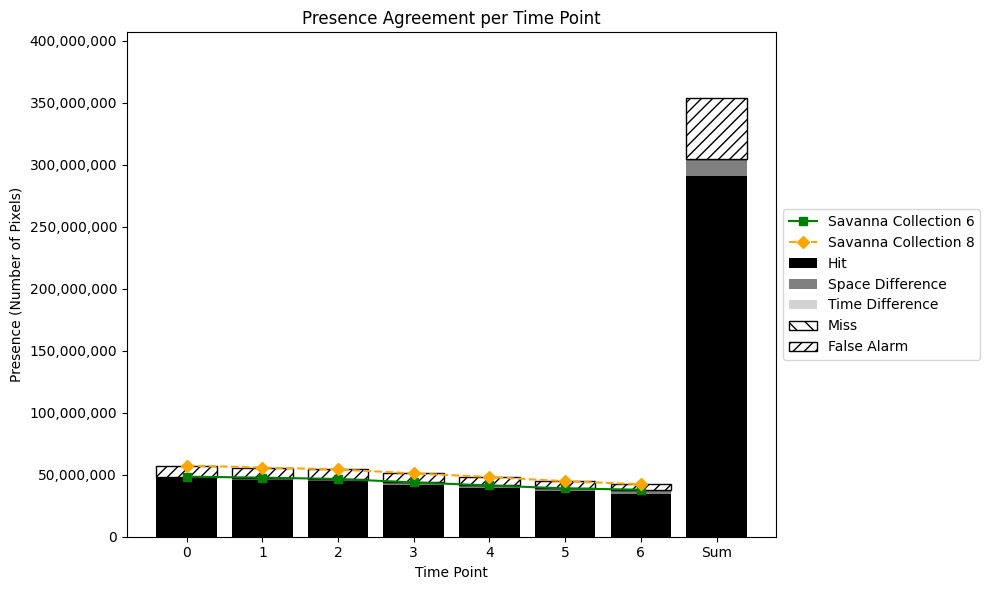

In [17]:
# --- Presence Agreement: Visualization ---

# This cell uses the pre-calculated presence metrics to generate the stacked bar chart.

# 1. Assemble arrays for plotting
categories = [str(i) for i in range(num_time_points)] + ['Sum']
x_pres = np.arange(len(categories))

hits_all   = np.append(hits_tp, hits_sum)
space_all  = np.append(space_diff_tp, space_sum)
time_all   = np.append(time_diff_tp, time_sum)
miss_all   = np.append(misses_tp, miss_sum)
false_all  = np.append(false_tp, false_sum)

# 2. Generate the plot
fig_presence, ax_presence = plt.subplots(figsize=(10, 6))

# Stacked bars for presence components
bottom = np.zeros(len(categories), dtype='int64')
ax_presence.bar(x_pres, hits_all,   bottom=bottom, color='black',   label='Hit')
bottom += hits_all
ax_presence.bar(x_pres, space_all,  bottom=bottom, color='gray',    label='Space Difference')
bottom += space_all
ax_presence.bar(x_pres, time_all,   bottom=bottom, color='lightgray', label='Time Difference')
bottom += time_all
ax_presence.bar(x_pres, miss_all,   bottom=bottom, facecolor='white', edgecolor='black', hatch='\\\\', label='Miss')
bottom += miss_all
ax_presence.bar(x_pres, false_all,  bottom=bottom, facecolor='white', edgecolor='black', hatch='///', label='False Alarm')
bottom += false_all # This line was missing

# Overlay lines for each series' total presence
ax_presence.plot(x_pres[:-1], px_sum_tp, color='green',  linestyle='-',  marker='s', label='Savanna Collection 6')
ax_presence.plot(x_pres[:-1], py_sum_tp, color='orange', linestyle='--', marker='D', label='Savanna Collection 8')

# 3. Format the plot
ax_presence.set_xlabel('Time Point')
ax_presence.set_ylabel('Presence (Number of Pixels)')
ax_presence.set_xticks(x_pres, categories)
ax_presence.set_title('Presence Agreement per Time Point')

# Make Y-axis limits and ticks dynamic based on the total height of the stacked bars
y_max = bottom.max() * 1.15 # Use the final bottom height and add 15% padding
ax_presence.set_ylim(0, y_max)

# Add a helper to format large numbers on the y-axis
from matplotlib.ticker import FuncFormatter
ax_presence.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))

ax_presence.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig_presence.tight_layout()

plt.show()

### 5.2 Stacked Bar Chart: Gross Change Components

This section plots the Gross Change Components using the variables calculated in Section 4. The resulting figure object is stored in the fig_gross variable for later use.

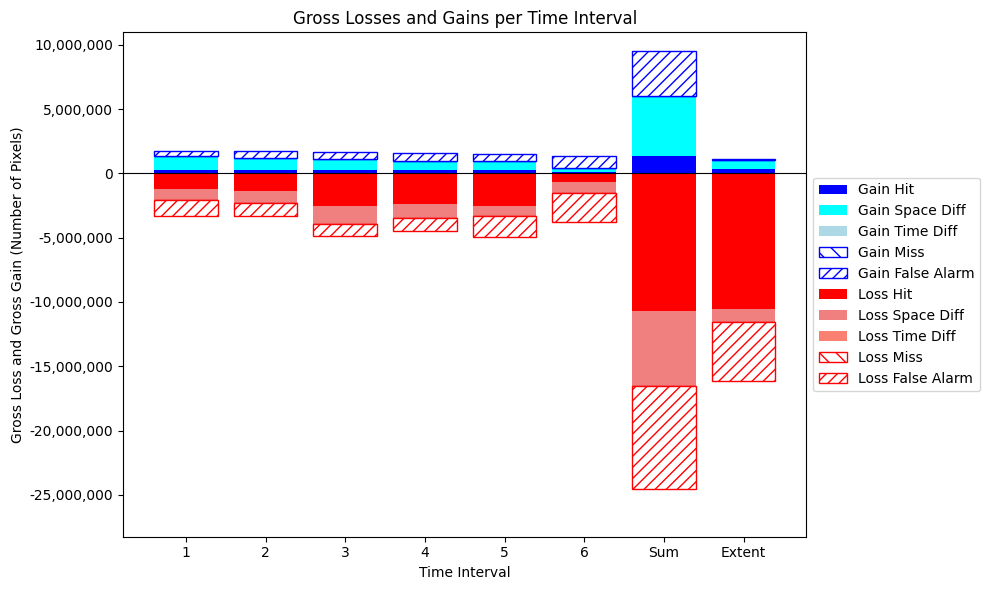

In [18]:
# --- Gross Change: Visualization ---

# This cell uses the pre-assembled arrays to generate the stacked bar chart for Gross Change.
categories = [str(i+1) for i in range(num_intervals)] + ['Sum', 'Extent']
x = np.arange(len(categories))

# Initialize the plot.
fig_gross, ax_gross = plt.subplots(figsize=(10, 6))

# Plot positive (gain) components above the x-axis.
bottom_gain = np.zeros(len(categories), dtype='int64')
ax_gross.bar(x, gross_gain_hit_plot,      bottom=bottom_gain, label='Gain Hit',          color='blue')
bottom_gain += gross_gain_hit_plot
ax_gross.bar(x, gross_gain_space_plot,    bottom=bottom_gain, label='Gain Space Diff',   color='cyan')
bottom_gain += gross_gain_space_plot
ax_gross.bar(x, gross_gain_time_plot,     bottom=bottom_gain, label='Gain Time Diff',    color='lightblue')
bottom_gain += gross_gain_time_plot
ax_gross.bar(x, gross_gain_miss_plot,     bottom=bottom_gain, label='Gain Miss',         facecolor='white', edgecolor='blue', hatch='\\\\')
bottom_gain += gross_gain_miss_plot
ax_gross.bar(x, gross_gain_fa_plot,       bottom=bottom_gain, label='Gain False Alarm',  facecolor='white', edgecolor='blue', hatch='///')
bottom_gain += gross_gain_fa_plot

# Plot negative (loss) components below the x-axis.
bottom_loss = np.zeros(len(categories), dtype='int64')
ax_gross.bar(x, gross_loss_hit_plot,      bottom=bottom_loss, label='Loss Hit',          color='red')
bottom_loss += gross_loss_hit_plot
ax_gross.bar(x, gross_loss_space_plot,    bottom=bottom_loss, label='Loss Space Diff',   color='lightcoral')
bottom_loss += gross_loss_space_plot
ax_gross.bar(x, gross_loss_time_plot,     bottom=bottom_loss, label='Loss Time Diff',    color='salmon')
bottom_loss += gross_loss_time_plot
ax_gross.bar(x, gross_loss_miss_plot,     bottom=bottom_loss, label='Loss Miss',         facecolor='white', edgecolor='red', hatch='\\\\')
bottom_loss += gross_loss_miss_plot
ax_gross.bar(x, gross_loss_fa_plot,       bottom=bottom_loss, label='Loss False Alarm',  facecolor='white', edgecolor='red', hatch='///')
bottom_loss += gross_loss_fa_plot

# Format plot with titles, labels, and a legend.
ax_gross.set_xticks(x, categories)
ax_gross.set_xlabel('Time Interval')
ax_gross.set_ylabel('Gross Loss and Gross Gain (Number of Pixels)')
ax_gross.set_title('Gross Losses and Gains per Time Interval')
ax_gross.axhline(0, color='black', linewidth=0.8)
ax_gross.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Set the y-axis limits dynamically based on the data.
y_max = bottom_gain.max() * 1.15
y_min = bottom_loss.min() * 1.15
ax_gross.set_ylim(y_min, y_max)

# Add a helper to format large numbers on the y-axis for readability.
from matplotlib.ticker import FuncFormatter
ax_gross.get_yaxis().set_major_formatter(FuncFormatter(lambda y, p: format(int(y), ',')))

fig_gross.tight_layout()
plt.show()

### 5.3 Stacked Bar Chart: Net Change Components

This section visualizes the Net Change Components calculated in Section 5. The chart shows the net effect of gains and losses for each component. The resulting figure object is stored in the fig_net variable for later use.

ValueError: One of max or min must be given

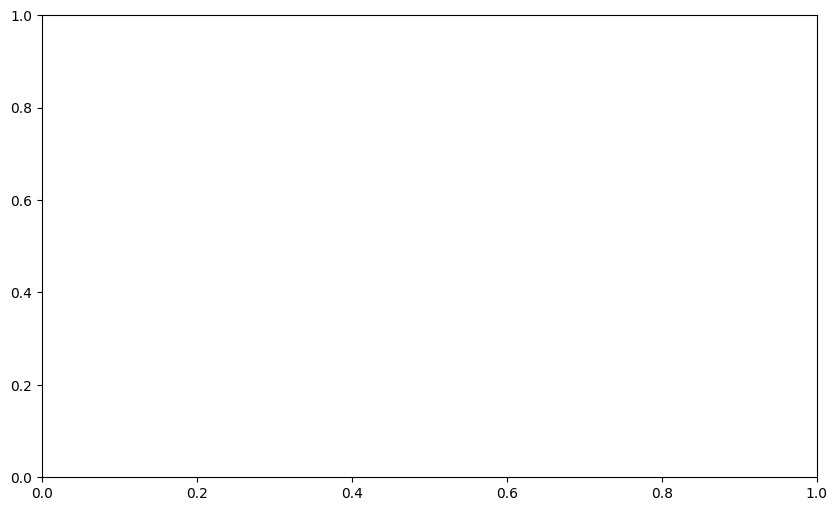

In [38]:
# Section 4.3: Plot Net Change Components

fig_net, ax_net = plt.subplots(figsize=(10, 6))
categories = ['1', '2', 'Sum', 'Extent']
x = np.arange(len(categories))

# Net Gains (empilha valores positivos acima do zero)
bottom_gain = np.zeros(len(categories))
ax_net.bar(x, net_hit_plot.clip(a_min=0), bottom=bottom_gain, label='Gain Hit', color='blue')
bottom_gain += net_hit_plot.clip(a_min=0)
ax_net.bar(x, net_time_plot.clip(a_min=0), bottom=bottom_gain, label='Gain Time Diff.', color='lightblue')
bottom_gain += net_time_plot.clip(a_min=0)
ax_net.bar(x, net_miss_plot.clip(a_min=0), bottom=bottom_gain, label='Gain Miss', facecolor='white', edgecolor='blue', hatch='\\\\')
bottom_gain += net_miss_plot.clip(a_min=0)
ax_net.bar(x, net_fa_plot.clip(a_min=0), bottom=bottom_gain, label='Gain False Alarm', facecolor='white', edgecolor='blue', hatch='///')

# Net Losses (empilha valores negativos abaixo do zero)
bottom_loss = np.zeros(len(categories))
ax_net.bar(x, net_hit_plot.clip(a_max=0), bottom=bottom_loss, label='Loss Hit', color='red')
bottom_loss += net_hit_plot.clip(a_max=0)
ax_net.bar(x, net_time_plot.clip(a_max=0), bottom=bottom_loss, label='Loss Time Diff.', color='lightcoral')
bottom_loss += net_time_plot.clip(a_max=0)
ax_net.bar(x, net_miss_plot.clip(a_max=0), bottom=bottom_loss, label='Loss Miss', facecolor='white', edgecolor='red', hatch='\\\\')
bottom_loss += net_miss_plot.clip(a_max=0)
ax_net.bar(x, net_fa_plot.clip(a_max=0), bottom=bottom_loss, label='Loss False Alarm', facecolor='white', edgecolor='red', hatch='///')

# Format
ax_net.set_xticks(x, categories)
ax_net.set_xlabel('Time Interval')
ax_net.set_ylabel('Net Loss and Net Gain')
ax_net.set_title('Net Change Components per Interval, Sum, and Extent')
ax_net.axhline(0, color='black', linewidth=0.8)
ax_net.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax_net.set_ylim(-7, 7)
fig_net.tight_layout()

plt.show()


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (4,) and arg 1 with shape (8,).

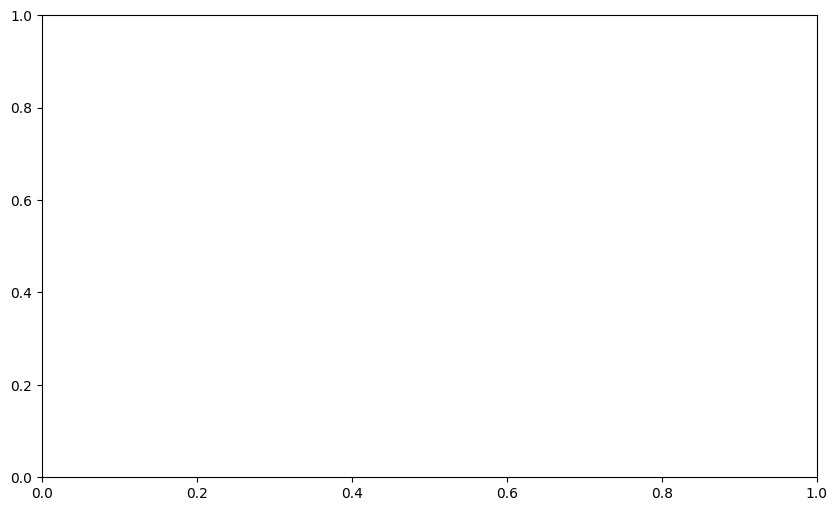

In [20]:
# Section 4.3: Plot Net Change Components

fig_net, ax_net = plt.subplots(figsize=(10, 6))
categories = ['1', '2', 'Sum', 'Extent']
x = np.arange(len(categories))

# Net Gains (above zero, azul)
bottom_gain = np.zeros(len(categories))
ax_net.bar(x, net_hit_plot.clip(min=0), bottom=bottom_gain, label='Gain Hit', color='blue')
bottom_gain += net_hit_plot.clip(min=0)
ax_net.bar(x, net_time_plot.clip(min=0), bottom=bottom_gain, label='Gain Time Diff.', color='lightblue')
bottom_gain += net_time_plot.clip(min=0)
ax_net.bar(x, net_miss_plot.clip(min=0), bottom=bottom_gain, label='Gain Miss', facecolor='white', edgecolor='blue', hatch='\\\\')
bottom_gain += net_miss_plot.clip(min=0)
ax_net.bar(x, net_fa_plot.clip(min=0), bottom=bottom_gain, label='Gain False Alarm', facecolor='white', edgecolor='blue', hatch='///')

# Net Losses (below zero, vermelho)
bottom_loss = np.zeros(len(categories))
ax_net.bar(x, net_hit_plot.clip(max=0), bottom=bottom_loss, label='Loss Hit', color='red')
bottom_loss += net_hit_plot.clip(max=0)
ax_net.bar(x, net_time_plot.clip(max=0), bottom=bottom_loss, label='Loss Time Diff.', color='lightcoral')
bottom_loss += net_time_plot.clip(max=0)
ax_net.bar(x, net_miss_plot.clip(max=0), bottom=bottom_loss, label='Loss Miss', facecolor='white', edgecolor='red', hatch='\\\\')
bottom_loss += net_miss_plot.clip(max=0)
ax_net.bar(x, net_fa_plot.clip(max=0), bottom=bottom_loss, label='Loss False Alarm', facecolor='white', edgecolor='red', hatch='///')

# Format the plot
ax_net.set_xticks(x, categories)
ax_net.set_xlabel('Time Interval')
ax_net.set_ylabel('Net Loss and Net Gain')
ax_net.set_title('Net Change Components per Interval, Sum, and Extent')
ax_net.axhline(0, color='black', linewidth=0.8)
ax_net.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax_net.set_ylim(-7, 7)
fig_net.tight_layout()

plt.show()


## 7. Exporting Results <a id="export"></a>

### 7.1 Save All Results to an Excel File
This section consolidates all the final calculated components into structured pandas DataFrames. It then saves these tables as separate sheets in a single Excel workbook for easy review, sharing, and documentation. The code is generic and will adapt to any number of time points.

In [ ]:
# Define output path for the Excel file
output_path = os.path.join(output_dir, metrics_excel)
os.makedirs(output_dir, exist_ok=True)

# Build the DataFrame for presence agreement (Graph 6.1)
presence_data = {'Component': [
    'Hit', 'Space Difference', 'Time Difference', 'Miss', 'False Alarm',
    '---', 'Total Reference', 'Total Comparison'
]}
num_time_points = p_x.shape[0]
for t in range(num_time_points):
    col_name = f'Time {t}'
    presence_data[col_name] = np.append(
        np.array([hits_tp[t], space_diff_tp[t], time_diff_tp[t], misses_tp[t], false_tp[t]]),
        [np.nan, px_sum_tp[t], py_sum_tp[t]]
    )
presence_data['Sum'] = np.append(
    np.array([hits_sum, space_sum, time_sum, miss_sum, false_sum]),
    [np.nan, p_x.sum(), p_y.sum()]
)
presence_df = pd.DataFrame(presence_data)

# Build the DataFrame for gross change components (Graph 6.2)
num_intervals = g_x.shape[0]
gross_change_data = {
    'Component': [
        'Gain Hit', 'Gain Space Difference', 'Gain Time Difference', 'Gain Miss', 'Gain False Alarm',
        'Loss Hit', 'Loss Space Difference', 'Loss Time Difference', 'Loss Miss', 'Loss False Alarm'
    ]
}
for i in range(num_intervals):
    col_name = f'Interval {i+1}'
    gross_change_data[col_name] = [
        gross_gain_hit_plot[i], gross_gain_space_plot[i], gross_gain_time_plot[i], gross_gain_miss_plot[i], gross_gain_fa_plot[i],
        -gross_loss_hit_plot[i], -gross_loss_space_plot[i], -gross_loss_time_plot[i], -gross_loss_miss_plot[i], -gross_loss_fa_plot[i]
    ]
gross_change_data['Sum'] = [
    gross_gain_hit_plot[-2], gross_gain_space_plot[-2], gross_gain_time_plot[-2], gross_gain_miss_plot[-2], gross_gain_fa_plot[-2],
    -gross_loss_hit_plot[-2], -gross_loss_space_plot[-2], -gross_loss_time_plot[-2], -gross_loss_miss_plot[-2], -gross_loss_fa_plot[-2]
]
gross_change_data['Extent'] = [
    gross_gain_hit_plot[-1], gross_gain_space_plot[-1], gross_gain_time_plot[-1], gross_gain_miss_plot[-1], gross_gain_fa_plot[-1],
    -gross_loss_hit_plot[-1], -gross_loss_space_plot[-1], -gross_loss_time_plot[-1], -gross_loss_miss_plot[-1], -gross_loss_fa_plot[-1]
]
gross_change_df = pd.DataFrame(gross_change_data)

# Build the DataFrame for net change components (Graph 6.3)
net_change_data = {
    'Component': [
        'Gain Hit', 'Gain Time Difference', 'Gain Miss', 'Gain False Alarm',
        'Loss Hit', 'Loss Time Difference', 'Loss Miss', 'Loss False Alarm'
    ]
}
for i in range(num_intervals):
    col_name = f'Interval {i+1}'
    net_change_data[col_name] = [
        net_gain_hit_plot[i], net_gain_time_plot[i], net_gain_miss_plot[i], net_gain_fa_plot[i],
        net_loss_hit_plot[i], net_loss_time_plot[i], net_loss_miss_plot[i], net_loss_fa_plot[i]
    ]
net_change_data['Sum'] = [
    net_gain_hit_plot[-2], net_gain_time_plot[-2], net_gain_miss_plot[-2], net_gain_fa_plot[-2],
    net_loss_hit_plot[-2], net_loss_time_plot[-2], net_loss_miss_plot[-2], net_loss_fa_plot[-2]
]
net_change_data['Extent'] = [
    net_gain_hit_plot[-1], net_gain_time_plot[-1], net_gain_miss_plot[-1], net_gain_fa_plot[-1],
    net_loss_hit_plot[-1], net_loss_time_plot[-1], net_loss_miss_plot[-1], net_loss_fa_plot[-1]
]
net_change_df = pd.DataFrame(net_change_data)

# Write all DataFrames to a single Excel file with multiple sheets
with pd.ExcelWriter(output_path) as writer:
    presence_df.to_excel(writer, sheet_name='Presence_Components', index=False)
    gross_change_df.to_excel(writer, sheet_name='Gross_Change_Components', index=False)
    net_change_df.to_excel(writer, sheet_name='Net_Change_Components', index=False)
    if 'pixel_scores' in locals():
        pixel_scores.to_excel(writer, sheet_name='Pixel_Wise_Scores')

print(f"All results have been successfully saved to:\n{output_path}")

### 7.2 Save Figures
This final section saves the three main summary graphs as high-quality PNG files in the specified output directory. Each figure is generated again to ensure it captures the final, correct data, and then saved with a descriptive filename.

In [ ]:
# Set up output directory and DPI for high-quality image export
high_resolution_dpi = 300
os.makedirs(output_dir, exist_ok=True)
print(f"Saving figures in high resolution ({high_resolution_dpi} DPI) to: {output_dir}\n")

# Save the Presence Agreement figure
fig1_path = os.path.join(output_dir, 'presence_agreement_chart.png')
fig_presence.savefig(fig1_path, bbox_inches='tight', dpi=high_resolution_dpi)
print(f"Figure 1 (Presence Agreement) saved as: {fig1_path}")

# Save the Gross Change Components figure
fig2_path = os.path.join(output_dir, 'gross_change_chart.png')
fig_gross.savefig(fig2_path, bbox_inches='tight', dpi=high_resolution_dpi)
print(f"Figure 2 (Gross Change) saved as: {fig2_path}")

# Save the Net Change Components figure
fig3_path = os.path.join(output_dir, 'net_change_chart.png')
fig_net.savefig(fig3_path, bbox_inches='tight', dpi=high_resolution_dpi)
print(f"Figure 3 (Net Change) saved as: {fig3_path}")